# Transit-Like Injections CARMA-Filtered

In [1]:
push!(LOAD_PATH, ".")

3-element Array{ByteString,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.4"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.4"      
 "."                                                               

In [2]:
using Colors
using Gadfly
using Kalman
using Transit

## Some Quick Tests of AR(1)

Create a filter with mean 1, variance 25, and timescale 3.

In [3]:
filt = Kalman.AR1KalmanFilter(1.0, 25.0, 3.0)

Kalman.AR1KalmanFilter(1.0,25.0,1.0,25.0,3.0)

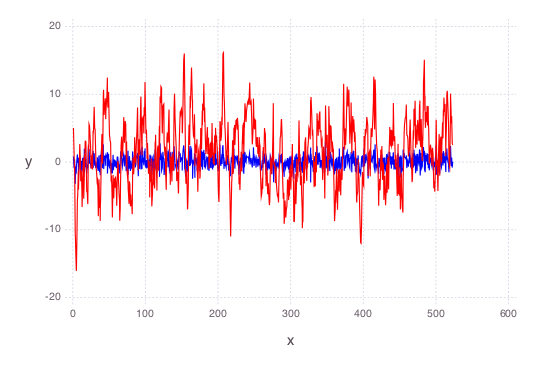

In [4]:
ts = cumsum(rand(1000))
dys = 0.1 + 0*ts
ys = Kalman.generate(filt, ts, dys)
wys = Kalman.whiten(filt, ts, ys, dys)
plot(layer(x=ts, y=ys, Geom.line, Theme(default_color=colorant"red")),
layer(x=ts, y=Kalman.whiten(filt, ts, ys, dys), Geom.line, Theme(default_color=colorant"blue")))

Let's check that the means and standard deviations work out:

In [5]:
print("Raw timeseries mean = $(mean(ys)), s.d. = $(std(ys))\n")
print("Whitened timeseries mean = $(mean(wys)), s.d. = $(std(wys))")

Raw timeseries mean = 1.3669935706543457, s.d. = 4.982579599872973
Whitened timeseries mean = 0.01603975275415794, s.d. = 0.9970829793516035

Let's check the log-likelihood:

In [6]:
function rawcov(ts, dys, var, tau)
    n = size(ts, 1)
    sigma = zeros(n,n)
    
    for i in 1:n
        for j in i:n
            sigma[i,j] = var*exp(-abs(ts[i]-ts[j])/tau)
            if j == i 
                sigma[i,j] += dys[i]*dys[i]
            else
                sigma[j,i] = sigma[i,j]
            end
        end
    end
    
    sigma
end

function rawloglik(ts, ys, dys, mu, var, tau)
    sigma = rawcov(ts, dys, var, tau)
    
    eigs = eigvals(sigma)
    
    n = size(ts, 1)
    
    -0.5*n*log(2.0*pi) - 0.5*sum(log(abs(eigs))) - 0.5*dot(ys-mu, sigma\(ys-mu))
end

rawloglik (generic function with 1 method)

In [7]:
println("Raw log likelihood = $(rawloglik(ts, ys, dys, 1.0, 25.0, 3.0))")
println("Kalman log likelihood = $(Kalman.log_likelihood(filt, ts, ys, dys))")

Raw log likelihood = -2284.9991846946436
Kalman log likelihood = -2284.999184694643


Woohoo!

## Testing the SNR against various noise parameters

First, the parameters of our transits:

Transit SNR = 19.26666662667415


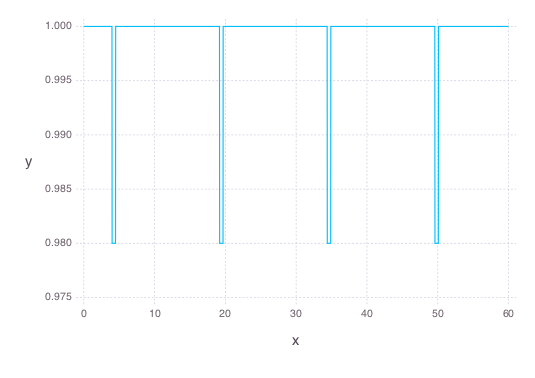

In [16]:
dt = 30.0/60.0/24.0 # dt in days
ts = collect(0:dt:60)
Tdur = 0.5 # 12 hour transits
P = 15 + rand() # 15 +/- 1 day period
T0 = 14*rand() # Random start phase
sigma_wn = 0.01
sigma_ar = 0.10
depth = sigma_wn*2
dflux = sigma_wn + 0.0*ts
tau_ar = P
mu_ar = 0.0
trans = Transit.transit_lightcurve(ts, P, T0, Tdur, depth)
println("Transit SNR = $(Transit.snr(trans, trans, sigma_wn))")
plot(x=ts, y=trans, Geom.line)

### Pure White Noise

Transit SNR = 19.772108283614124


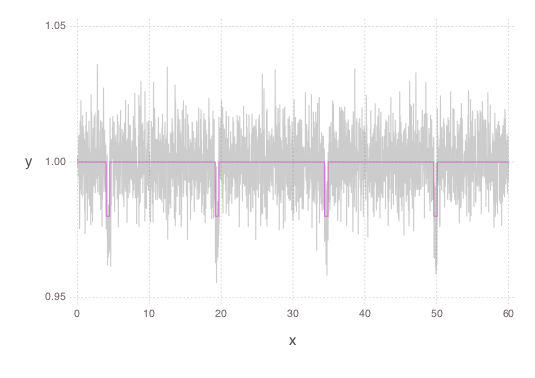

BLS SNR = 18.94380314522045
New SNR = 20.228618254815633


In [17]:
noise = sigma_wn * randn(size(ts,1))
flux = trans + noise
cs = distinguishable_colors(2)
println("Transit SNR = $(Transit.snr(flux,trans,std(flux)))")
println("BLS SNR = $(Transit.bls_snr(flux,trans))")
println("New SNR = $(Transit.new_snr(flux, trans))")
plot(layer(x=ts, y=flux, Geom.line, Theme(default_color=RGBA(cs[1],0.2))),
layer(x=ts,y=trans,Geom.line,Theme(default_color=cs[2])))

### Short-period noise (around 1-sample correlations)

Transit SNR = 0.0


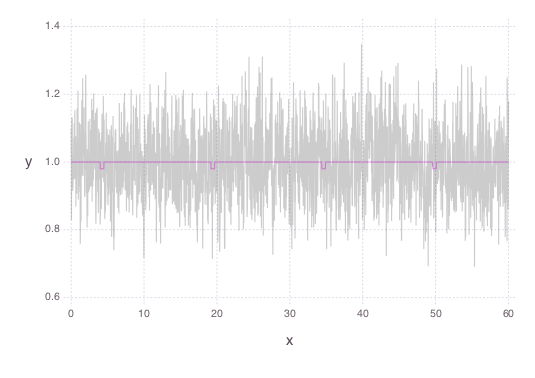

BLS SNR = -0.15222332367378183
New SNR = -0.1471491765381478


In [18]:
filt = Kalman.AR1KalmanFilter(0.0, sigma_ar^2, dt)
noise = Kalman.generate(filt, ts, dflux)
flux = trans + noise
cs = distinguishable_colors(2)
println("Transit SNR = $(Transit.snr(flux,trans,std(flux)))")
println("BLS SNR = $(Transit.bls_snr(flux,trans))")
println("New SNR = $(Transit.new_snr(flux, trans))")
plot(layer(x=ts, y=flux, Geom.line, Theme(default_color=RGBA(cs[1],0.2))),
layer(x=ts,y=trans,Geom.line,Theme(default_color=cs[2])))

And if we whiten...?

Whitened SNR = 0.18513479231969515


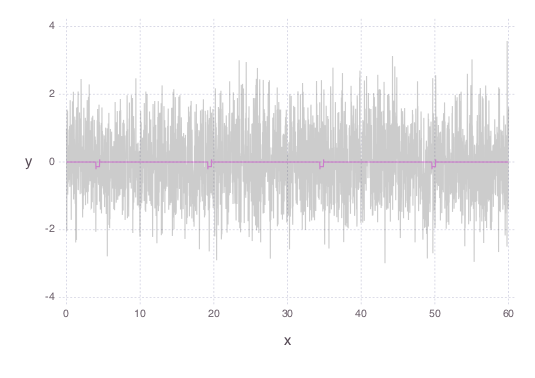

In [19]:
filt = Kalman.AR1KalmanFilter(1.0, sigma_ar^2, dt)
wflux = Kalman.whiten(filt, ts, flux, dflux)
wtrans = Kalman.whiten(filt, ts, trans, dflux)
println("Whitened SNR = $(Transit.snr(wflux, wtrans, 1.0))")
plot(layer(x=ts, y=wflux, Geom.line, Theme(default_color=RGBA(cs[1], 0.2))),
layer(x=ts, y=wtrans, Geom.line, Theme(default_color=cs[2])))

### Longer Period Correlations (around ``Tdur``)

Raw SNR = 0.0


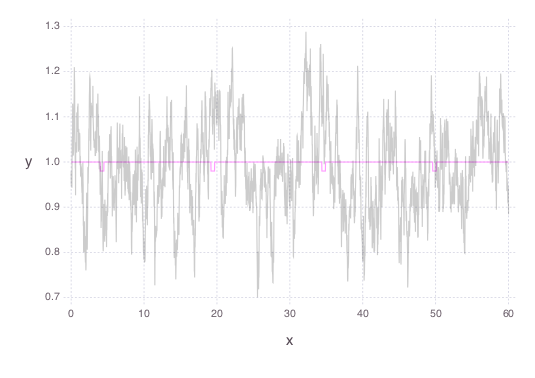

BLS SNR = -5.068109069717232
New SNR = -5.193759519333531


In [20]:
filt = Kalman.AR1KalmanFilter(0.0, sigma_ar^2, Tdur)
noise = Kalman.generate(filt, ts, dflux)
flux = trans + noise
println("Raw SNR = $(Transit.snr(flux, trans, std(flux)))")
println("BLS SNR = $(Transit.bls_snr(flux, trans))")
println("New SNR = $(Transit.new_snr(flux, trans))")
plot(layer(x=ts, y=flux, Geom.line, Theme(default_color=RGBA(cs[1], 0.2))),
layer(x=ts, y=trans, Geom.line, Theme(default_color=cs[2])))

...and if we whiten?

Whitened SNR = 0.8866120557067384


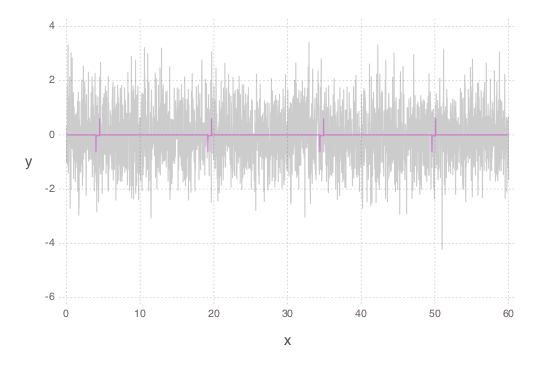

In [21]:
filt = Kalman.AR1KalmanFilter(1.0, sigma_ar^2, Tdur)
wflux = Kalman.whiten(filt, ts, flux, dflux)
wtrans = Kalman.whiten(filt, ts, trans, dflux)
println("Whitened SNR = $(Transit.snr(wflux, wtrans, 1.0))")
plot(layer(x=ts, y=wflux, Geom.line, Theme(default_color=RGBA(cs[1],0.2))),
layer(x=ts, y=wtrans, Geom.line, Theme(default_color=cs[2])))

### And for very long-period correlations?

Raw SNR = 0.0


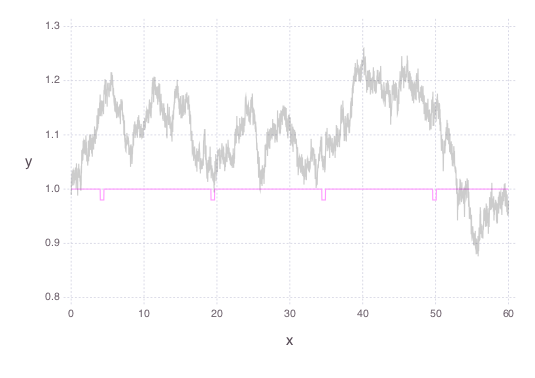

BLS SNR = 1.2983880872159574
New SNR = 1.0177252322105386


In [22]:
filt = Kalman.AR1KalmanFilter(0.0, sigma_ar^2, P)
noise = Kalman.generate(filt, ts, dflux)
flux = trans + noise
println("Raw SNR = $(Transit.snr(flux, trans, std(flux)))")
println("BLS SNR = $(Transit.bls_snr(flux, trans))")
println("New SNR = $(Transit.new_snr(flux, trans))")
plot(layer(x=ts, y=flux, Geom.line, Theme(default_color=RGBA(cs[1], 0.2))),
layer(x=ts, y=trans, Geom.line, Theme(default_color=cs[2])))

Whitened SNR = 5.56031242106391


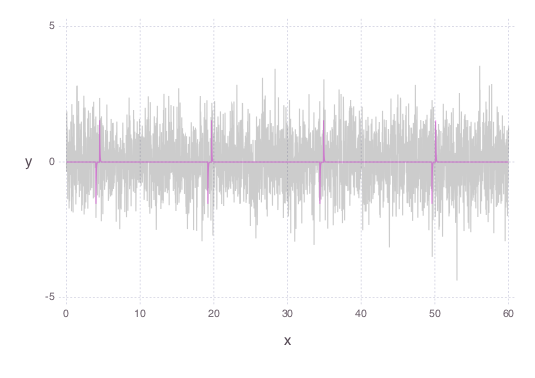

In [23]:
filt = Kalman.AR1KalmanFilter(1.0, sigma_ar^2, P)
wflux = Kalman.whiten(filt, ts, flux, dflux)
wtrans = Kalman.whiten(filt, ts, trans, dflux)
println("Whitened SNR = $(Transit.snr(wflux, wtrans, 1.0))")
plot(layer(x=ts, y=wflux, Geom.line, Theme(default_color=RGBA(cs[1], 0.2))),
layer(x=ts, y=wtrans, Geom.line, Theme(default_color=cs[2])))

### *Really* Long Correlations

Raw SNR = 6.118217958904014


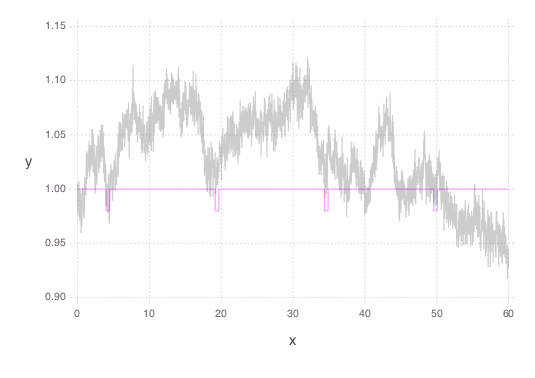

BLS SNR = 14.07140409371554
New SNR = 6.378129982574294


In [26]:
filt = Kalman.AR1KalmanFilter(0.0, sigma_ar^2, ts[end]-ts[1])
noise = Kalman.generate(filt, ts, dflux)
flux = trans + noise
println("Raw SNR = $(Transit.snr(flux, trans, std(flux)))")
println("BLS SNR = $(Transit.bls_snr(flux, trans))")
println("New SNR = $(Transit.new_snr(flux, trans))")
plot(layer(x=ts, y=flux, Geom.line, Theme(default_color=RGBA(cs[1], 0.2))),
layer(x=ts, y=trans, Geom.line, Theme(default_color=cs[2])))

Whitened SNR = 3.909938982528112


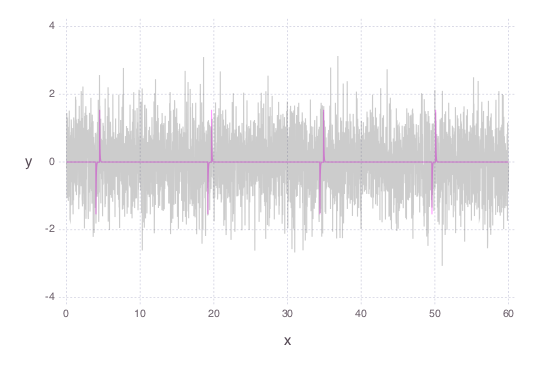

In [27]:
filt = Kalman.AR1KalmanFilter(1.0, sigma_ar^2, P)
wflux = Kalman.whiten(filt, ts, flux, dflux)
wtrans = Kalman.whiten(filt, ts, trans, dflux)
println("Whitened SNR = $(Transit.snr(wflux, wtrans, 1.0))")
plot(layer(x=ts, y=wflux, Geom.line, Theme(default_color=RGBA(cs[1], 0.2))),
layer(x=ts, y=wtrans, Geom.line, Theme(default_color=cs[2])))